In [54]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense,Input,Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import SGD,Adam
import pandas as pd


In [2]:
df = pd.read_csv("D:/public_dat/train.csv")
df['Sentence'] = df['Sentence'].str.lower()

In [3]:
df.head()

,Id,Sentence,Entity_1,Entity_2,Relation
0,1,rising interest rates affects borrowing costs ...,Interest Rates,borrowers,affects
1,3,market volatility affects traders by leading t...,Market Volatility,Traders,affects
2,4,strong corporate earnings affect shareholders ...,Corporate Earnings,Shareholders,affects
3,5,regulatory changes affect financial institutio...,Regulatory Changes,Financial Institutions,affects
4,6,investor behavior affects market trends and as...,Investor Behavior,Market Trends,affects


In [4]:
df['Sentence']

0       rising interest rates affects borrowing costs ...
1       market volatility affects traders by leading t...
2       strong corporate earnings affect shareholders ...
3       regulatory changes affect financial institutio...
4       investor behavior affects market trends and as...
                              ...                        
7687    sharp, which sells aquos smartphones, fell zer...
7688    short gross sales come when an investor sells ...
7689    homeowners have a good chance of keeping their...
7690    german broker lang & schwarz tradecenter ag, w...
7691    global funds sold more south korean stocks tha...
Name: Sentence, Length: 7692, dtype: object

In [50]:

sentences=[]
for jok in df['Sentence']:
    sentences.append(jok)
word1=[]
for jok in df['Entity_1']:
    word1.append(jok)
word2=[]
for jok in df['Entity_2']:
    word2.append(jok)
relations=[]
for jok in df['Relation']:
    relations.append(jok)
    
# Separate data into input (sentences) and output (relations)
#sentences = np.array(sentences)
#word1 = np.array([df['Entity_1']])
#word2 = np.array([df['Entity_2']])
#relations = np.array([df['Relation']])
#sentences=sentences.flatten()
#word1=word1.flatten()
#word2=word2.flatten()
#relations=relations.flatten()
#print(relations)
# Tokenize sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences + word1 + word2)
vocab_size = len(tokenizer.word_index) + 1

# Encode sentences and relations
X_sentences = tokenizer.texts_to_sequences(sentences)
X_word1 = tokenizer.texts_to_sequences(word1)
X_word2 = tokenizer.texts_to_sequences(word2)
max_len = 256 #max(len(seq) for seq in X_sentences)
X_sentences = pad_sequences(X_sentences, maxlen=max_len)
X_word1 = pad_sequences(X_word1, maxlen=1)
X_word2 = pad_sequences(X_word2, maxlen=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(relations)  # Assuming relations are categorical strings


In [88]:

# Split data into train and test sets
X_sentences_train, X_sentences_test, X_word1_train, X_word1_test, X_word2_train, X_word2_test, y_train, y_test = train_test_split(X_sentences, X_word1, X_word2, y, test_size=0.1, random_state=6)

# Define LSTM model with named input layers
embedding_dim = 150
num_classes = len(set(relations))

input_sentences = Input(shape=(max_len,), name='input_sentences')
input_word1 = Input(shape=(1,), name='input_word1')
input_word2 = Input(shape=(1,), name='input_word2')

embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)
lstm_layer = LSTM(units=256, dropout=0.0, recurrent_dropout=0.0)
lstm_layer2 = LSTM(units=128, dropout=0.0, recurrent_dropout=0.0)
lstm_layer3 = LSTM(units=64, dropout=0.0, recurrent_dropout=0.0)
dense_layer = Dense(num_classes, activation='softmax')

embedding_sentences = embedding_layer(input_sentences)
embedding_word1 = embedding_layer(input_word1)
embedding_word2 = embedding_layer(input_word2)

lstm_output_sentences = lstm_layer(embedding_sentences)
embedding_layer2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim)
embedding_sentences2 = embedding_layer2(lstm_output_sentences)
lstm_output_word1 = lstm_layer2(embedding_sentences2)
embedding_layer3 = Embedding(input_dim=vocab_size, output_dim=embedding_dim)
embedding_sentences3 = embedding_layer2(lstm_output_word1)
lstm_output_word2 = lstm_layer3(embedding_sentences3)
lstm_output_word12 = lstm_layer(embedding_word1)
lstm_output_word22 = lstm_layer(embedding_word2)

concatenated = Concatenate()([lstm_output_sentences,lstm_output_word1,lstm_output_word2])
output = dense_layer(concatenated)

In [89]:

#print("Shape of X_sentences_train:", X_sentences_train.shape)
#print("Shape of X_sentences_test:", X_sentences_test.shape)
#print(X_sentences_train)
#max_len
print(output)

KerasTensor(type_spec=TensorSpec(shape=(None, 12), dtype=tf.float32, name=None), name='dense_13/Softmax:0', description="created by layer 'dense_13'")


In [90]:

model = Model(inputs=[input_sentences], outputs=output)

# Compile the model
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-7
decay = 0.0
optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, decay=decay)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit({"input_sentences": X_sentences_train}, y_train, epochs=10, batch_size=10, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate({"input_sentences": X_sentences_test}, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/10
623/623 [==============================] - 33s 47ms/step - loss: 1.9973 - accuracy: 0.3121 - val_loss: 2.0089 - val_accuracy: 0.3593
Epoch 2/10
623/623 [==============================] - 28s 46ms/step - loss: 1.2351 - accuracy: 0.6202 - val_loss: 0.9197 - val_accuracy: 0.7590
Epoch 3/10
623/623 [==============================] - 28s 46ms/step - loss: 0.4672 - accuracy: 0.8746 - val_loss: 0.5215 - val_accuracy: 0.8759
Epoch 4/10
623/623 [==============================] - 29s 47ms/step - loss: 0.2213 - accuracy: 0.9425 - val_loss: 0.5291 - val_accuracy: 0.8788
Epoch 5/10
623/623 [==============================] - 28s 46ms/step - loss: 0.1416 - accuracy: 0.9629 - val_loss: 0.5731 - val_accuracy: 0.8687
Epoch 6/10
623/623 [==============================] - 28s 46ms/step - loss: 0.0983 - accuracy: 0.9717 - val_loss: 0.5611 - val_accuracy: 0.8773
Epoch 7/10
623/623 [==============================] - 29s 46ms/step - loss: 0.0804 - accuracy: 0.9778 - val_loss: 0.5508 - val_accuracy:

In [91]:
df2 = pd.read_csv("D:/public_dat/test.csv")
df2['Sentence'] = df2['Sentence'].str.lower()

In [92]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict classes for test data
y_pred = model.predict(X_sentences_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes = label_encoder.inverse_transform(y_pred_classes)
y_test = label_encoder.inverse_transform(y_test)
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)

25/25 [==============================] - 1s 23ms/step
Confusion Matrix:
[[69  0  1  0  1  3  0  0  1  1  0  0]
 [ 1 60  0  1  0  2  0  0  6  0  1  0]
 [ 0  3 51  0  0  2  0  0  0  0  1  0]
 [ 0  0  0 52  0  1  0  0  1  1  1  0]
 [ 0  0  0  0 53  0  0  0  0  0  0  0]
 [ 3  0  0  1  2 55  1  2  3  2  1  1]
 [ 0  0  0  0  0  0 51  0  0  0  0  1]
 [ 0  1  0  0  0  2  0 64  1  0  0  1]
 [ 0  0  0  0  0  7  0  1 60  0  0  0]
 [ 0  2  1  0  0  3  1  0  0 66  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 46  0]
 [ 0  1  0  0  0  2  0  1  2  0  0 72]]


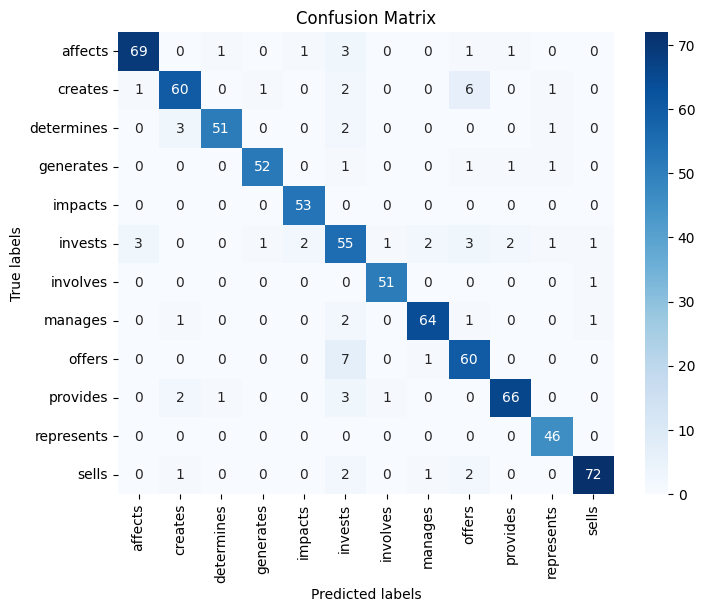

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
classes = np.unique(y_test)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [94]:
sentences2=[]
for jok in df2['Sentence']:
    sentences2.append(jok)
word12=[]
for jok in df2['Entity_1']:
    word12.append(jok)
word22=[]
for jok in df2['Entity_2']:
    word22.append(jok)
    
# Separate data into input (sentences) and output (relations)
#sentences = np.array(sentences)
#word1 = np.array([df['Entity_1']])
#word2 = np.array([df['Entity_2']])
#relations = np.array([df['Relation']])
#sentences=sentences.flatten()
#word1=word1.flatten()
#word2=word2.flatten()
#relations=relations.flatten()
#print(relations)
# Tokenize sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences + word1 + word2)
vocab_size = len(tokenizer.word_index) + 1

# Encode sentences and relations
X_sentences2 = tokenizer.texts_to_sequences(sentences2)
X_word12 = tokenizer.texts_to_sequences(word12)
X_word22 = tokenizer.texts_to_sequences(word22)
max_len = 256
X_sentences2 = pad_sequences(X_sentences2, maxlen=max_len)
X_word12 = pad_sequences(X_word12, maxlen=1)
X_word22 = pad_sequences(X_word22, maxlen=1)

In [95]:

X_sentences_text2 = tokenizer.sequences_to_texts(X_sentences2)
#print(X_sentences_text2)

In [96]:
df2['Id']

0       8920
1         64
2       2755
3       6871
4       7305
        ... 
1315    8344
1316    5943
1317    4424
1318    4457
1319    6012
Name: Id, Length: 1320, dtype: int64

In [97]:
pred = model.predict({"input_sentences": X_sentences2})
predicted_labels = np.argmax(pred, axis=1)
predicted_labels_text = label_encoder.inverse_transform(predicted_labels)

# Display test input sentences and corresponding predicted labels

for sentence,senteces1, predicted_label in zip(word12,word22, predicted_labels_text):
  
    print(f"Input word1: {sentence}")
    print(f"Input word2: {senteces1}")
    print(f"Predicted Label: {predicted_label}")
    print()
data={'Id':df2['Id'],'Relation':predicted_labels_text}
dfk=pd.DataFrame(data)

42/42 [==============================] - 2s 28ms/step
Input word1: Equipment
Input word2: Safety
Predicted Label: affects

Input word1: tax evasion
Input word2: government revenues
Predicted Label: affects

Input word1: flat market
Input word2: FX revenues
Predicted Label: affects

Input word1: lengthy shutdown
Input word2: welfare, food stamps and programs
Predicted Label: affects

Input word1: Property tax
Input word2: Annual expenses
Predicted Label: involves

Input word1: product recalls
Input word2: sales
Predicted Label: affects

Input word1: lapse in appropriations
Input word2: Federal Contractors
Predicted Label: affects

Input word1: Credit card
Input word2: Credit card companies' profits
Predicted Label: affects

Input word1: industrial users
Input word2: Investment Program
Predicted Label: affects

Input word1: shutdown
Input word2: civilian workers at the service academies
Predicted Label: affects

Input word1: cancellation notices
Input word2: population
Predicted Label: a

In [98]:
display(dfk)

,Id,Relation
0,8920,affects
1,64,affects
2,2755,affects
3,6871,affects
4,7305,involves
...,...,...
1315,8344,sells
1316,5943,offers
1317,4424,sells
1318,4457,sells


In [83]:

# saving the dataframe
dfk.to_csv(r'D:\Lithin\codlang\Submission.csv')